# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
src_path = 'C:/Users/robbe/Downloads/hecktor_train_v3/hecktor-main/src/'
sys.path.append(src_path)
import os
import pathlib
import numpy as np
import nibabel as nib
import sys
from data import utils
from nibabel.testing import data_path
import ImageViewer3D as I3D

import argparse
import glob
import imp
import subprocess
import yaml

import seaborn as sns
import pandas as pd

import chainer
import chainer.functions as F
import cv2 as cv
from chainer import Variable
from chainer import serializers
import cupy
import infer

from scipy.ndimage import zoom

# Load conditional GAN

In [85]:
all_paths = utils.get_paths_to_patient_files('C:/Users/robbe/Downloads/hecktor_train_v3/hecktor_train/synthetic/')
result_dir ='C:/Users/robbe/tgan-master/tgan-master/results/PrivacyTest-last20withheld'

fsgen, vgen, vdis = infer.get_models(result_dir, 28000)
fsgen.to_gpu()
vgen.to_gpu()
vdis.to_gpu()

numsyn = 200
n=10

dis_output= np.ones(200,dtype='float32')

noise = np.random.rand(64,201,64,64)*0.4
cr_masks = np.load('cropped_masks.npy')
cr_masks = (cr_masks+noise)*255/1.4
cr_imgs = np.load('cropped_imgs.npy')
cr_2ch = np.concatenate((np.expand_dims(cr_imgs,-1),np.expand_dims(cr_masks,-1)),axis=-1)
cr_2ch = cr_2ch.astype('int')

for j in range(numsyn//n):
    #reals = np.expand_dims(np.transpose(cr_2ch,[2,3,0,1,4])[:,:,16:-16,n*j:n*j+n,0],axis=3)
    #masks =  np.expand_dims(np.transpose(cr_2ch,[2,3,0,1,4])[:,:,16:-16,n*j:n*j+n,1],axis=3)
    cr = np.transpose((cr_2ch[16:-16,n*j:n*j+n,:,:,:]/255*2-1),[1,4,0,2,3]).astype('float32') #n, 1, z, x, y
    cr = chainer.Variable(cr)
    cr.to_gpu()
    
    t = np.squeeze(cupy.asnumpy(vdis(cr).data))
    dis_output[n*j:n*j+n] = t

# cr.to_gpu()

## Histogram of discriminator outputs for each sample

Within set mean/std:  0.0219 , 0.0174
Outside set mean/std:  -0.0218 , 0.0209
Hedges g: 2.46


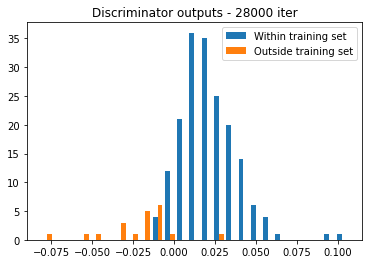

In [86]:
m1 = np.mean(dis_output[:-20])
m2 = np.mean(dis_output[-20:])
std1 = np.std(dis_output[:-20])
std2 = np.std(dis_output[-20:])

plt.hist([dis_output[0:-20], dis_output[-20:]],25);
plt.legend(['Within training set','Outside training set'])
plt.title('Discriminator outputs - 28000 iter');
print('Within set mean/std: ', '{0:.3g}'.format(m1),',','{0:.3g}'.format(std1))
print('Outside set mean/std: ', '{0:.3g}'.format(m2),',','{0:.3g}'.format(std2))

sdpooled = np.sqrt(((len(dis_output[:-20])-1)*std1**2 + (len(dis_output[-20:])-1)*std2**2)/(len(dis_output)-2))
g = (m1-m2)/sdpooled

print('Hedges g:','{0:.3g}'.format(g))

## Randomly sample 20 orange/blue

In [87]:
import random
# take second element for sort
def takeFirst(elem):
    return elem[0]

#For each experiment: Rank each sample and calc accuracy of membership attack
experiments = 1000
res = np.zeros(experiments)

for i in range(experiments):
    shuffled = random.sample(list(dis_output[:-20]), 20)
    sub_pop = (np.concatenate((shuffled,dis_output[-20:])),np.concatenate((np.ones(20),np.zeros(20))))
    sub_pop = [(sub_pop[0][i],sub_pop[1][i]) for i in range(40)]
    sub_pop_sorted = sorted(sub_pop,key=takeFirst,reverse=True)
    res[i] = (np.sum(j for i, j in sub_pop_sorted[:20])/20)

print('{0:.3g}'.format(np.mean(res)),'{0:.3g}'.format(np.std(res)))

0.943 0.0171


<ipython-input-87-8eaa32868a3f>:15: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  res[i] = (np.sum(j for i, j in sub_pop_sorted[:20])/20)


## Load unconditional GAN and test privacy

In [88]:
all_paths = utils.get_paths_to_patient_files('C:/Users/robbe/Downloads/hecktor_train_v3/hecktor_train/synthetic/')
result_dir ='C:/Users/robbe/tgan-master/tgan-master/results/PrivacyTest-last20witheld-unconditional'

fsgen, vgen, vdis = infer.get_models(result_dir, 28000)
fsgen.to_gpu()
vgen.to_gpu()
vdis.to_gpu()

numsyn = 200
n=10

dis_output= np.ones(200,dtype='float32')

cr_imgs = np.load('cropped_imgs.npy')

for j in range(numsyn//n):
    cr = np.transpose((cr_imgs[16:-16,n*j:n*j+n,:,:]/255*2-1),[1,0,2,3]).astype('float32') #n, 1, z, x, y
    cr = np.expand_dims(cr,1)
    cr = chainer.Variable(cr)
    cr.to_gpu()
    
    t = np.squeeze(cupy.asnumpy(vdis(cr).data))
    dis_output[n*j:n*j+n] = t

Within set mean/std:  -0.00531 , 0.024
Outside set mean/std:  -0.047 , 0.0186
Hedges g: 1.78


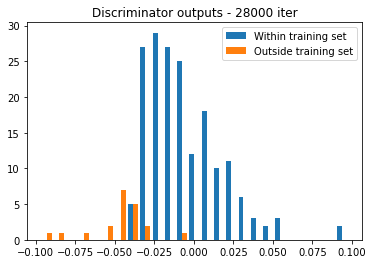

In [89]:
m1 = np.mean(dis_output[:-20])
m2 = np.mean(dis_output[-20:])
std1 = np.std(dis_output[:-20])
std2 = np.std(dis_output[-20:])

plt.hist([dis_output[0:-20], dis_output[-20:]],25);
plt.legend(['Within training set','Outside training set'])
plt.title('Discriminator outputs - 28000 iter');
print('Within set mean/std: ', '{0:.3g}'.format(m1),',','{0:.3g}'.format(std1))
print('Outside set mean/std: ', '{0:.3g}'.format(m2),',','{0:.3g}'.format(std2))

sdpooled = np.sqrt(((len(dis_output[:-20])-1)*std1**2 + (len(dis_output[-20:])-1)*std2**2)/(len(dis_output)-2))
g = (m1-m2)/sdpooled

print('Hedges g:','{0:.3g}'.format(g))

In [90]:
#For each experiment: Rank each sample and calc accuracy of membership attack
experiments = 1000
res = np.zeros(experiments)

for i in range(experiments):
    shuffled = random.sample(list(dis_output[:-20]), 20)
    sub_pop = (np.concatenate((shuffled,dis_output[-20:])),np.concatenate((np.ones(20),np.zeros(20))))
    sub_pop = [(sub_pop[0][i],sub_pop[1][i]) for i in range(40)]
    sub_pop_sorted = sorted(sub_pop,key=takeFirst,reverse=True)
    res[i] = (np.sum(j for i, j in sub_pop_sorted[:20])/20)

print('{0:.3g}'.format(np.mean(res)),'{0:.3g}'.format(np.std(res)))

0.905 0.0235


<ipython-input-90-0e347e7b075d>:10: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  res[i] = (np.sum(j for i, j in sub_pop_sorted[:20])/20)


# Interpolation Test

In [91]:
#Want to take real masks and interpolate them instead. First do a straight comparison of real masks to 
#interpolated to see how different they are
#Then compare generated images based on the masks
#Then try dice score comparison.

def calc_dice(a,b):
    #a and b are N-D binary images
    c = a.astype('int')+b.astype('int')
    tf = np.sum(c[c==1])
    tt = np.sum(c[c==2])
    
    return tt/(tf+tt)

In [92]:
cr_masks = np.load('cropped_masks.npy')
cr_interp = cr_masks[::2,:,:,:]
cr_interp = zoom(cr_interp, (2, 1, 1, 1))

In [93]:
dice_scores = [(calc_dice(cr_masks[:,i,:,:],np.round(cr_interp[:,i,:,:]))) for i in range(200)]
print('Mean dice score between interpolated and real masks:' , '{0:.3g}'.format(np.nanmean(dice_scores)))

<ipython-input-91-543a14bf81ae>:12: RuntimeWarning: invalid value encountered in long_scalars
  return tt/(tf+tt)


Mean dice score between interpolated and real masks: 0.892


## Generate 20 conditional images with real masks and interpolated masks 

In [94]:
import torch
from torch.utils.data import DataLoader
sys.path.append('C:\\Users\\robbe\\Downloads\\hecktor_train_v3\\hecktor-main\\src\\')
import dataset
import transforms
import losses
import metrics
import trainer

all_paths = utils.get_paths_to_patient_files('C:/Users/robbe/Downloads/hecktor_train_v3/hecktor_train/synthetic/')
result_dir ='C:/Users/robbe/tgan-master/tgan-master/results/PrivacyTest-last20withheld'

fsgen, vgen, vdis = infer.get_models(result_dir, 28000)
fsgen.to_gpu()
vgen.to_gpu()
vdis.to_gpu()

%cd C:/Users/robbe/Downloads/hecktor_train_v3/hecktor-main
from src import models
%cd C:/Users/robbe/tgan-master/tgan-master
    
m = models.FastSmoothSENormDeepUNet_supervision_skip_no_drop(in_channels=1, n_cls=2, n_filters=24) #2,2,12 or 1,2,24
weights = torch.load('C:/Users/robbe/Downloads/hecktor_train_v3/hecktor-main/hecktor_training_cropped_PETONLYv4/best_model_weights.pt')
m.load_state_dict(weights)

numsyn = 200
n=10

cr_interp = (cr_interp+noise)*255/1.4
cr_2ch_interp = np.concatenate((np.expand_dims(cr_imgs,-1),np.expand_dims(cr_interp,-1)),axis=-1)
cr_2ch_interp = cr_2ch.astype('int')

sl = []
sl_interp = []
real_masks = np.load('cropped_masks.npy')
real_masks = np.transpose(real_masks,[2,3,0,1]) #x,y,z,n

for j in range(numsyn//n):

    cr = np.transpose(np.expand_dims(cr_2ch_interp[16:-16,n*j:n*j+n,:,:,1]/255*2-1,axis=-1),[1,4,0,2,3]).astype('float32') #n, 1, z, x, y
    cr = chainer.Variable(cr)
    cr.to_gpu()
    y, _, _ = infer.make_conditional_video(fsgen, vgen, n,cr)
    y = y * 20 + 20
    
    cr = np.transpose(np.expand_dims(cr_2ch[16:-16,n*j:n*j+n,:,:,1]/255*2-1,axis=-1),[1,4,0,2,3]).astype('float32') #n, 1, z, x, y
    cr = chainer.Variable(cr)
    cr.to_gpu()
    z, _, _ = infer.make_conditional_video(fsgen, vgen, n,cr)
    z = z * 20 + 20
    
    for i in range(n):
        
        syn_img_interp = np.pad(np.transpose(y,[3,4,2,0,1])[:,:,:,i,0],((0,0),(0,0),(16,16)),'edge')
        syn_img_norm_interp = (syn_img_interp-np.mean(syn_img_interp))/(np.std(syn_img_interp)+1e-3)
        input1_interp = np.expand_dims(syn_img_norm_interp,[0, 1])
        
        syn_img = np.pad(np.transpose(z,[3,4,2,0,1])[:,:,:,i,0],((0,0),(0,0),(16,16)),'edge')
        syn_img_norm = (syn_img-np.mean(syn_img))/(np.std(syn_img)+1e-3)
        input1 = np.expand_dims(syn_img_norm,[0, 1])
        
        with torch.no_grad():
            ct_gtvt_img = m(torch.FloatTensor(input1)).cpu().detach().numpy()[0,0,:,:,:]
            ct_gtvt_img_interp = m(torch.FloatTensor(input1_interp)).cpu().detach().numpy()[0,0,:,:,:]

        ct_gtvt_img[ct_gtvt_img>0.5]=1
        ct_gtvt_img[ct_gtvt_img<0.5]=0
        ct_gtvt_img_interp[ct_gtvt_img_interp>0.5]=1
        ct_gtvt_img_interp[ct_gtvt_img_interp<0.5]=0
        
        
        s = calc_dice(ct_gtvt_img,real_masks[:,:,:,n*j+i])
        sl.append(s)
        s_interp = calc_dice(ct_gtvt_img_interp,real_masks[:,:,:,n*j+i])
        sl_interp.append(s_interp)
        
        if (j==19 & i == 4):
            I3D.ImageSliceViewer3D(syn_img_interp)
            I3D.ImageSliceViewer3D(ct_gtvt_img)
            I3D.ImageSliceViewer3D(syn_img)
            I3D.ImageSliceViewer3D(ct_gtvt_img_interp)


C:\Users\robbe\Downloads\hecktor_train_v3\hecktor-main
C:\Users\robbe\tgan-master\tgan-master


In [95]:
I3D.ImageSliceViewer3D(syn_img_interp)
I3D.ImageSliceViewer3D(ct_gtvt_img)
I3D.ImageSliceViewer3D(syn_img)
I3D.ImageSliceViewer3D(ct_gtvt_img_interp)

interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

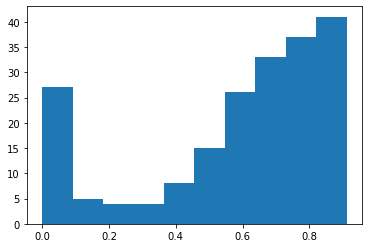

In [96]:
plt.hist(sl);

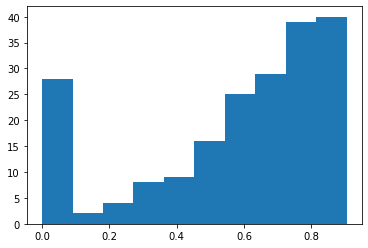

In [97]:
plt.hist(sl_interp);

In [98]:
print('{0:.3g}'.format(np.mean(sl)),'{0:.3g}'.format(np.mean(sl_interp)))

0.577 0.574
